In [13]:
# import necessary libraries for training xgboost model
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import time

In [14]:
# load the data
data_dir = '../mimic_data_after_preprocess/training_set_smote25.csv'
train = pd.read_csv(data_dir)
test = pd.read_csv('../mimic_data_after_preprocess/testing_set25.csv')

In [15]:
# since there is no instance in age group 1, remove this feature
train = train.drop(['age_1'], axis=1)
test = test.drop(['age_1'], axis=1)

In [16]:
# split the data into train and test
# train, test = train_test_split(debug_data, test_size=0.2)
# get features and labels
train_features = train.drop(['adverse_flag'], axis=1)
train_labels = train['adverse_flag']
test_features = test.drop(['adverse_flag'], axis=1)
test_labels = test['adverse_flag']

In [17]:
print('train features shape: ', train_features.shape)
print('train labels shape: ', train_labels.shape)
print('test features shape: ', test_features.shape)
print('test labels shape: ', test_labels.shape)
print('train features columns: ', train_features.columns)
print('test features columns: ', test_features.columns)

train features shape:  (90256, 25)
train labels shape:  (90256,)
test features shape:  (18478, 25)
test labels shape:  (18478,)
train features columns:  Index(['Unnamed: 0', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7',
       'age_8', 'gender', 'n_hosp', 'anti_narcotic', 'narcotic',
       'n_anti_narcotic', 'n_narcotic', 'oxymorphone', 'oxycodone', 'morphine',
       'meperidine', 'hydromorphone', 'hydrocodone', 'fentanyl', 'codeine',
       'buprenorphine', 'methadone', 'naloxone'],
      dtype='object')
test features columns:  Index(['subject_id', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7',
       'age_8', 'gender', 'n_hosp', 'anti_narcotic', 'narcotic',
       'n_anti_narcotic', 'n_narcotic', 'oxymorphone', 'oxycodone', 'morphine',
       'meperidine', 'hydromorphone', 'hydrocodone', 'fentanyl', 'codeine',
       'buprenorphine', 'methadone', 'naloxone'],
      dtype='object')


In [18]:
train_features = train_features.drop(['Unnamed: 0'], axis=1)
# train_features = train_features.drop(['subject_id'], axis=1)
test_features = test_features.drop(['subject_id'], axis=1)

In [19]:
print('train features shape: ', train_features.shape)
print('train labels shape: ', train_labels.shape)
print('test features shape: ', test_features.shape)
print('test labels shape: ', test_labels.shape)
print('train features columns: ', train_features.columns)
print('test features columns: ', test_features.columns)

train features shape:  (90256, 24)
train labels shape:  (90256,)
test features shape:  (18478, 24)
test labels shape:  (18478,)
train features columns:  Index(['age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'gender',
       'n_hosp', 'anti_narcotic', 'narcotic', 'n_anti_narcotic', 'n_narcotic',
       'oxymorphone', 'oxycodone', 'morphine', 'meperidine', 'hydromorphone',
       'hydrocodone', 'fentanyl', 'codeine', 'buprenorphine', 'methadone',
       'naloxone'],
      dtype='object')
test features columns:  Index(['age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'gender',
       'n_hosp', 'anti_narcotic', 'narcotic', 'n_anti_narcotic', 'n_narcotic',
       'oxymorphone', 'oxycodone', 'morphine', 'meperidine', 'hydromorphone',
       'hydrocodone', 'fentanyl', 'codeine', 'buprenorphine', 'methadone',
       'naloxone'],
      dtype='object')


In [20]:
test_features, vali_features, test_labels, vali_labels = train_test_split(test_features,
                                                                            test_labels,
                                                                            test_size=0.5)

In [21]:
print('train features shape: ', train_features.shape)
print('test features shape: ', test_features.shape)
print('vali features shape: ', vali_features.shape)

train features shape:  (90256, 24)
test features shape:  (9239, 24)
vali features shape:  (9239, 24)


In [22]:
# use grid search to find the best parameters
model = xgb.XGBClassifier()
param_grid = {'max_depth': [3, 5, 8, 10],
              'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
              'n_estimators': [50, 100, 150, 200, 300, 400],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2],
             "objective": ['binary:logistic'],
             "tree_method": ['hist']}
clf = GridSearchCV(model, param_grid, n_jobs=8, verbose=3, scoring='roc_auc')

In [23]:
# find parameters for gpu and cpu, and compare time cost
# start_gpu = time.time()
# clf.fit(vali_features, vali_labels)
# time_cost_gpu = time.time() - start_gpu
# print('time cost of gpu: ', time_cost_gpu)

In [24]:
# output the best parameters
# print(clf.best_params_)

In [25]:

model_cpu = xgb.XGBClassifier(max_depth=3,
                          learning_rate=0.1,
                          n_estimators=200,
                          min_child_weight = 1,
                          objective='binary:logistic',
                          tree_method='hist')
start_cpu = time.time()
model_cpu.fit(train_features, train_labels)
time_cost_cpu = time.time() - start_cpu
print('time cost of cpu: ', time_cost_cpu)

model = xgb.XGBClassifier(max_depth=10,
                          learning_rate=0.1,
                          n_estimators=200,
                          objective='binary:logistic',
                          tree_method='gpu_hist')
start = time.time()
model.fit(train_features, train_labels)
time_cost = time.time() - start
print('time cost of gpu: ', time_cost)


model_2 = xgb.XGBClassifier(max_depth=5,
                          learning_rate=0.1,
                          n_estimators=50,
                          min_child_weight=1,
                            gamma = 0.1,
                          objective='binary:logistic',
                          tree_method='hist')
# model_2 = xgb.XGBClassifier(max_depth=3,
#                           learning_rate=0.03,
#                           n_estimators=300,
#                           min_child_weight=3,
#                             gamma = 0.2,
#                           objective='binary:logistic',
#                           tree_method='hist')
# model_2 = xgb.XGBClassifier(max_depth=5,
#                           learning_rate=0.1,
#                           n_estimators=50,
#                           min_child_weight=5,
#                             gamma = 0.0,
#                           objective='binary:logistic',
#                           tree_method='hist')
start_gpu2 = time.time()
model_2.fit(train_features, train_labels)
time_cost_gpu2 = time.time() - start_gpu2
print('time cost of gpu model 2: ', time_cost_gpu2)

time cost of cpu:  0.24249553680419922
time cost of gpu:  4.551958084106445
time cost of gpu model 2:  0.1142740249633789


In [26]:
# test the gpu model

# calculate the metrics for two models:
# recall is true positive / (true positive + false negative)
# precision is true positive / (true positive + false positive)
# f1 is 2 * (precision * recall) / (precision + recall)
# auc is the area under the roc curve
# roc is the curve of true positive rate and false positive rate
preds = model_cpu.predict(test_features)
recall = recall_score(test_labels, preds)
precision = precision_score(test_labels, preds)
f1 = f1_score(test_labels, preds)
auc = roc_auc_score(test_labels, preds)
print('recall: ', recall)
print('precision: ', precision)
print('f1: ', f1)
print('auc: ', auc)
print()

preds_1 = model.predict(test_features)
recall_1 = recall_score(test_labels, preds_1)
precision_1 = precision_score(test_labels, preds_1)
f1_1 = f1_score(test_labels, preds_1)
auc_1 = roc_auc_score(test_labels, preds_1)
print('recall_1: ', recall)
print('precision_1: ', precision)
print('f1_1: ', f1)
print('auc_1: ', auc)
print()
# test the gpu model 2
preds_2 = model_2.predict(test_features)
recall_2 = recall_score(test_labels, preds_2)
precision_2 = precision_score(test_labels, preds_2)
f1_2 = f1_score(test_labels, preds_2)
auc_2 = roc_auc_score(test_labels, preds_2)
print('recall_2: ', recall_2)
print('precision_2: ', precision_2)
print('f1_2: ', f1_2)
print('auc_2: ', auc_2)
print()

# test model on training set
preds_train = model_cpu.predict(train_features)
recall_train = recall_score(train_labels, preds_train)
precision_train = precision_score(train_labels, preds_train)
f1_train = f1_score(train_labels, preds_train)
auc_train = roc_auc_score(train_labels, preds_train)
print('recall_train: ', recall_train)
print('precision_train: ', precision_train)
print('f1_train: ', f1_train)
print('auc_train: ', auc_train)


recall:  0.5130434782608696
precision:  0.2942643391521197
f1:  0.37400950871632327
auc:  0.7408152234239191

recall_1:  0.5130434782608696
precision_1:  0.2942643391521197
f1_1:  0.37400950871632327
auc_1:  0.7408152234239191

recall_2:  0.4782608695652174
precision_2:  0.3235294117647059
f1_2:  0.3859649122807018
auc_2:  0.7263654220175959

recall_train:  0.5746496039000609
precision_train:  0.8243662083763809
f1_train:  0.6772213880002611
auc_train:  0.7720211526182669


In [27]:
# get number of true positive, false positive, true negative, false negative of model 2
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels, preds_2).ravel()
print('true positive: ', tp)
print('false positive: ', fp)
print('true negative: ', tn)
print('false negative: ', fn)

# compute recall, precision, f1, auc for model 2
recall_2 = tp / (tp + fn)
precision_2 = tp / (tp + fp)
f1_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2)
auc_2 = roc_auc_score(test_labels, preds_2)
print('recall_2: ', recall_2)
print('precision_2: ', precision_2)
print('f1_2: ', f1_2)
print('auc_2: ', auc_2)

true positive:  110
false positive:  230
true negative:  8779
false negative:  120
recall_2:  0.4782608695652174
precision_2:  0.3235294117647059
f1_2:  0.3859649122807018
auc_2:  0.7263654220175959


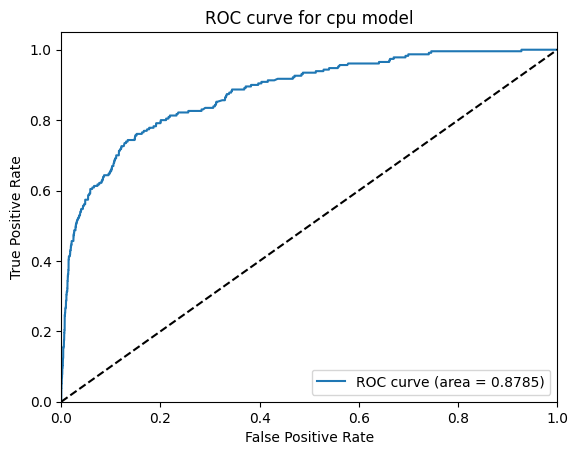

In [28]:
# plot the roc curve for cpu model

import matplotlib.pyplot as plt
probas_ = model_cpu.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probas_[:, 1])
auc = roc_auc_score(test_labels, probas_[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cpu model')
plt.legend(loc="lower right")
plt.show()

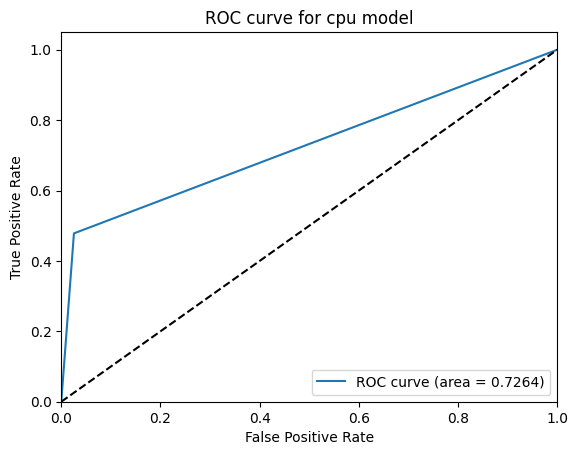

In [29]:
import matplotlib.pyplot as plt
preds = model_2.predict(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, preds)
auc = roc_auc_score(test_labels, preds)
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cpu model')
plt.legend(loc="lower right")
plt.show()


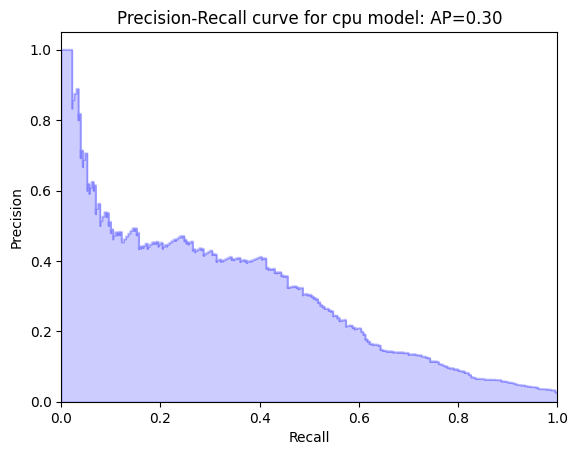

In [30]:
# plot the precision recall curve for cpu model

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(test_labels, probas_[:, 1])
average_precision = average_precision_score(test_labels, probas_[:, 1])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for cpu model: AP={0:0.2f}'.format(
          average_precision))
plt.show()

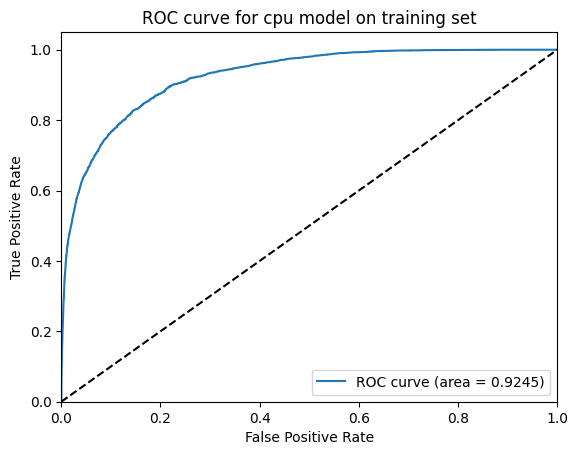

In [31]:
# plot the roc curve for cpu model

import matplotlib.pyplot as plt
probas_ = model_cpu.predict_proba(train_features)
fpr, tpr, thresholds = roc_curve(train_labels, probas_[:, 1])
auc = roc_auc_score(train_labels, probas_[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cpu model on training set')
plt.legend(loc="lower right")
plt.show()

In [39]:
# find the optimal threshold on roc curve for model 2
probas_ = model_cpu.predict_proba(test_features)
fpr, tpr, thresholds = roc_curve(test_labels, probas_[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
thresholdOpt = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholdOpt, gmeans[ix]))
print('tpr: ', tpr[ix], 'fpr: ', fpr[ix])
print('precision: ', precision_score(test_labels, probas_[:,1] >= thresholdOpt))
print('recall: ', recall_score(test_labels, probas_[:,1] >= thresholdOpt))
print('f1_score: ', f1_score(test_labels, probas_[:,1] >= thresholdOpt))

# find the threshold that maximize the f1 score
thresholds_f1 = np.arange(0, 1, 0.01)
f1_scores = []
fpr_f1 = []
tpr_f1 = []
accuracy_f1 = []
precision_f1 = []
for threshold in thresholds_f1:
    preds_f1 = probas_[:,1] >= threshold
    f1_scores.append(f1_score(test_labels, preds_f1))
    tn, fp, fn, tp = confusion_matrix(test_labels, preds_f1).ravel()
    fpr_f1.append(fp / (fp + tn))
    tpr_f1.append(tp / (tp + fn))
    accuracy_f1.append((tp + tn) / (tp + tn + fp + fn))
    precision_f1.append(tp / (tp + fp))
thresholdOpt_f1 = thresholds_f1[np.argmax(f1_scores)]
print('thresholdOpt: ', thresholdOpt_f1)
print('tpr: ', tpr_f1[np.argmax(f1_scores)], 'fpr: ', fpr_f1[np.argmax(f1_scores)])
print('precision: ', precision_f1[np.argmax(f1_scores)])
print('recall: ', recall_score(test_labels, probas_[:,1] >= thresholdOpt_f1))
print('f1_score: ', np.max(f1_scores))
print('accuracy: ', accuracy_f1[np.argmax(f1_scores)])
# precision = tp / (tp + fp)

Best Threshold=0.200080, G-Mean=0.803
tpr:  0.7608695652173914 fpr:  0.15184815184815184
precision:  0.11341542449773169
recall:  0.7608695652173914
f1_score:  0.19740552735476596
thresholdOpt:  0.66
tpr:  0.41304347826086957 fpr:  0.015318015318015318
precision:  0.40772532188841204
recall:  0.41304347826086957
f1_score:  0.41036717062634986
accuracy:  0.970451347548436


In [47]:
print(precision_f1)

[0.024894469098387273, 0.03377473590239548, 0.03691386764216827, 0.03919134598333038, 0.04129904261310306, 0.04421699078812692, 0.046854377474703036, 0.050611657471815785, 0.05469366289771233, 0.056921801602652665, 0.06207744314689613, 0.06639004149377593, 0.07542675664946408, 0.08101157308186883, 0.08476881233000906, 0.0879695672848312, 0.09227683049147442, 0.09488666315234581, 0.09938922820655191, 0.1056422569027611, 0.11341542449773169, 0.11958041958041958, 0.12463343108504399, 0.1324345757335448, 0.134953897736798, 0.13922942206654992, 0.14102564102564102, 0.14381591562799617, 0.14741035856573706, 0.15400624349635797, 0.16100766703176342, 0.16627906976744186, 0.17401960784313725, 0.1828793774319066, 0.19099590723055934, 0.19746121297602257, 0.20501474926253688, 0.2073170731707317, 0.21669341894060995, 0.21710526315789475, 0.22487223168654175, 0.2328042328042328, 0.23626373626373626, 0.24423076923076922, 0.25301204819277107, 0.25661914460285135, 0.2616033755274262, 0.270089285714285

In [45]:
# store the model, and the tpr with regard to different thresholds
import pickle
with open('./models/model_xgboost.pkl', 'wb') as f:
    pickle.dump(model_cpu, f)
with open('./models/thresholds.pkl', 'wb') as f:
    pickle.dump(thresholds_f1, f)
with open('./models/tpr_xgboost.pkl', 'wb') as f:
    pickle.dump(tpr_f1, f)
with open('./models/precision_xgboost.pkl', 'wb') as f:
    pickle.dump(precision_f1, f)


In [34]:
pred_probas_default = probas_[:,1] >= 0.5
pred_probas_opt = probas_[:,1] >= thresholdOpt_f1

accuracy_default = accuracy_score(test_labels, pred_probas_default)
accuracy_opt = accuracy_score(test_labels, pred_probas_opt)

recall_default = recall_score(test_labels, pred_probas_default)
recall_opt = recall_score(test_labels, pred_probas_opt)

precision_default = precision_score(test_labels, pred_probas_default)
precision_opt = precision_score(test_labels, pred_probas_opt)

f1_default = f1_score(test_labels, pred_probas_default)
f1_opt = f1_score(test_labels, pred_probas_opt)

print('accuracy_default: ', accuracy_default)
print('accuracy_opt: ', accuracy_opt)
print('recall_default: ', recall_default)
print('recall_opt: ', recall_opt)
print('precision_default: ', precision_default)
print('precision_opt: ', precision_opt)
print('f1_default: ', f1_default)
print('f1_opt: ', f1_opt)

thresholdOpt = thresholdOpt_f1

accuracy_default:  0.957246455244074
accuracy_opt:  0.970451347548436
recall_default:  0.5130434782608696
recall_opt:  0.41304347826086957
precision_default:  0.2942643391521197
precision_opt:  0.40772532188841204
f1_default:  0.37400950871632327
f1_opt:  0.41036717062634986


In [35]:
# Measure the fairness of model. Sensitive feature is gender
preds_ = model_cpu.predict(test_features)
probas_ = model_cpu.predict_proba(test_features)
pred_thre = probas_[:, 1] > thresholdOpt
print("male: ", len(test_features[test_features['gender']==0]))
print("female: ", len(test_features[test_features['gender']==1]))
print("male real disorder: ", sum(test_labels[test_features['gender']==0]))
print("female real disorder: ", sum(test_labels[test_features['gender']==1]))
print("male predicted disorder: ", sum(preds_[test_features['gender']==0]))
print("female predicted disorder: ", sum(preds_[test_features['gender']==1]))
print()
print("male predicted disorder: ", sum(pred_thre[test_features['gender']==0]))
print("female predicted disorder: ", sum(pred_thre[test_features['gender']==1]))

male:  4932
female:  4307
male real disorder:  96
female real disorder:  134
male predicted disorder:  203
female predicted disorder:  198

male predicted disorder:  114
female predicted disorder:  119


In [48]:
type(probas_)

numpy.ndarray

In [36]:
# Measure the Disparate Impact, Equal Opportunity Difference,
# Statistical Parity Difference, Average Odds Difference
group_female_pred = pred_thre[test_features['gender']==1]
group_female = test_labels[test_features['gender']==1]
group_male_pred = pred_thre[test_features['gender']==0]
group_male = test_labels[test_features['gender']==0]

female_rate = sum(group_female_pred)/len(group_female)
male_rate = sum(group_male_pred)/len(group_male)
disparate_impact = female_rate/male_rate
print("Disparate Impact:", disparate_impact)

from sklearn.metrics import confusion_matrix
tn_female, fp_female, fn_female, tp_female = confusion_matrix(group_female, group_female_pred).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(group_male, group_male_pred).ravel()

accuracy_female = sum(group_female_pred==group_female)/len(group_female_pred)
recall_female = tp_female / (tp_female + fn_female)
fpr_female = fp_female/(fp_female+tn_female)
precision_female = tp_female / (tp_female + fp_female)
f1_female = 2 * (precision_female * recall_female) / (precision_female + recall_female)

accuracy_male = sum(group_male_pred==group_male)/len(group_male_pred)
recall_male = tp_male / (tp_male + fn_male)
fpr_male = fp_male/(fp_male+tn_male)
precision_male = tp_male / (tp_male + fp_male)
f1_male = 2 * (precision_male * recall_male) / (precision_male + recall_male)

print("accuracy", accuracy_female, accuracy_male, accuracy_female-accuracy_male)
print("recall ", recall_female,  recall_male, recall_female-recall_male)
print("fpr ", fpr_female,  fpr_male, fpr_female-fpr_male)
print("precision ", precision_female,  precision_male, precision_female-precision_male)
print("f1 ", f1_female,  f1_male, f1_female-f1_male)

Disparate Impact: 1.195336844549265
accuracy 0.9654051543998142 0.9748580697485807 -0.009452915348766466
recall  0.3880597014925373 0.4479166666666667 -0.05985696517412936
fpr  0.016055595494847832 0.014681555004135649 0.0013740404907121827
precision  0.4369747899159664 0.37719298245614036 0.05978180745982603
f1  0.41106719367588934 0.4095238095238095 0.0015433841520798297


In [50]:
# load the simulation data and test the model on it. Then print the fairness metrics
sim_data = pd.read_csv('../mimic_data_after_preprocess/simulation_set25.csv', index_col='subject_id')
sim_features = sim_data.drop(['age_1','adverse_flag'], axis=1)
sim_labels = sim_data['adverse_flag']
sim_preds = model_cpu.predict(sim_features)
sim_probas = model_cpu.predict_proba(sim_features)

# compute the fairness metrics
sim_recall = recall_score(sim_labels, sim_preds)
sim_precision = precision_score(sim_labels, sim_preds)
sim_f1 = f1_score(sim_labels, sim_preds)
sim_accuracy = accuracy_score(sim_labels, sim_preds)

print("sim_recall: ", sim_recall)
print("sim_precision: ", sim_precision)
print("sim_f1: ", sim_f1)
print("sim_accuracy: ", sim_accuracy)


sim_recall:  0.4934086629001883
sim_precision:  0.27637130801687765
sim_f1:  0.35429344151453684
sim_accuracy:  0.9586544289548878


In [ ]:
from sklearn.model_selection import StratifiedKFold
from numpy import interp
import sklearn
import matplotlib.pyplot as plt
X_res_vis = train.drop(['adverse_flag'], axis=1)
y_resampled = train['adverse_flag']

cv = StratifiedKFold(n_splits=10, shuffle=True)
classifier = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 8, n_estimators = 200, objective = 'binary:logistic')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X_res_vis, y_resampled):
    X_train = X_res_vis.iloc[train]
    Y_train = y_resampled.iloc[train]
    X_test = X_res_vis.iloc[test]
    Y_test = y_resampled[test]
    probas_ = classifier.fit(X_train, Y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Extreme Gradient Boosting')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),  shadow=True, ncol=2)
plt.show()